In [2]:
from functions import parameters as param
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
from functions.utilities.preprocess import make_copy


In [3]:
proj_param = param.Proj_Param()

In [4]:
proj_param.data_files_dict.items()

dict_items([('ratings', {'path': '/ml-1m/ratings.dat', 'cols': ['userId', 'movieId', 'rating', 'timestamp']}), ('movies', {'path': '/ml-1m/movies.dat', 'cols': ['movieId', 'title', 'genres']}), ('users', {'path': '/ml-1m/users.dat', 'cols': ['userId', 'gender', 'age', 'occupation', 'zip-code']})])

In [5]:
df_dict = {}
for name, file_dict in proj_param.data_files_dict.items():
    csv_path = proj_param.data_folder + file_dict.get('path')
    df_dict[f'df_{name}'] = pd.read_csv(csv_path,sep='::',engine='python',names=file_dict.get('cols'),encoding='latin1')


In [6]:
# Deep copy to keep the dictionary df untouched

df_ratings = make_copy(df_dict.get('df_ratings'))
df_movies = make_copy(df_dict.get('df_movies'))
df_users = make_copy(df_dict.get('df_users'))

print(df_users)

Function is being called
Function is being called
Function is being called
      userId gender  age  occupation zip-code
0          1      F    1          10    48067
1          2      M   56          16    70072
2          3      M   25          15    55117
3          4      M   45           7    02460
4          5      M   25          20    55455
...      ...    ...  ...         ...      ...
6035    6036      F   25          15    32603
6036    6037      F   45           1    76006
6037    6038      F   56           1    14706
6038    6039      F   45           0    01060
6039    6040      M   25           6    11106

[6040 rows x 5 columns]


In [7]:
display(df_ratings.head(10))
display(df_movies.head(10))
display(df_users.head(10))

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


In [8]:
display(df_ratings.info())
display(df_movies.info())
display(df_users.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  3883 non-null   int64 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userId      6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


None

In [9]:
print(df_ratings['rating'].nunique())

5


In [10]:
df_ratings['rating'].value_counts()

rating
4    348971
3    261197
5    226310
2    107557
1     56174
Name: count, dtype: int64

In [11]:
df_ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [12]:
df_movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [13]:
df_movies['genres'] = df_movies['genres'].str.split('|')  # Split the genre for every movie 

In [14]:
df_movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]
5,6,Heat (1995),"[Action, Crime, Thriller]"
6,7,Sabrina (1995),"[Comedy, Romance]"
7,8,Tom and Huck (1995),"[Adventure, Children's]"
8,9,Sudden Death (1995),[Action]
9,10,GoldenEye (1995),"[Action, Adventure, Thriller]"


In [15]:
from collections import Counter
genre_freq = Counter(g for genre in df_movies['genres'] for g in genre)

In [16]:
type(genre_freq)

collections.Counter

In [17]:
df_genre = pd.DataFrame.from_dict(data=[genre_freq])
df_genre

,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,105,251,1200,283,68,471,1603,503,211,492,343,276,127,143,114,106,44,68


In [18]:
# Plot genre freq 
genre_freq = dict(genre_freq)
genre_freq

{'Animation': 105,
 "Children's": 251,
 'Comedy': 1200,
 'Adventure': 283,
 'Fantasy': 68,
 'Romance': 471,
 'Drama': 1603,
 'Action': 503,
 'Crime': 211,
 'Thriller': 492,
 'Horror': 343,
 'Sci-Fi': 276,
 'Documentary': 127,
 'War': 143,
 'Musical': 114,
 'Mystery': 106,
 'Film-Noir': 44,
 'Western': 68}

In [19]:
df_genre = df_genre.T.reset_index()


In [20]:
df_genre.columns = ['genre', 'count']

In [21]:
df_genre

,genre,count
0,Animation,105
1,Children's,251
2,Comedy,1200
3,Adventure,283
4,Fantasy,68
5,Romance,471
6,Drama,1603
7,Action,503
8,Crime,211
9,Thriller,492


In [22]:
import seaborn as sns

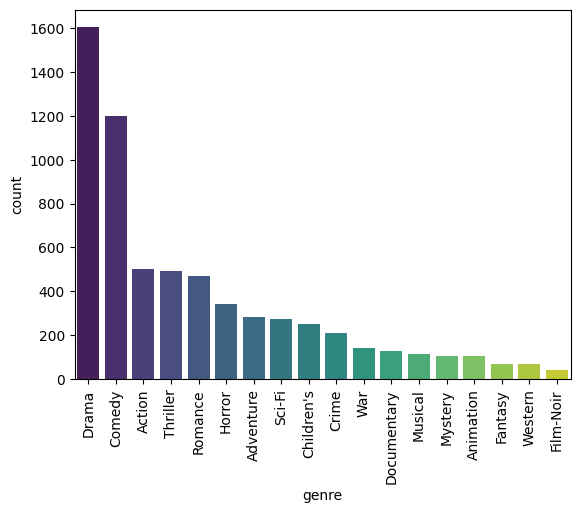

In [23]:
sns.barplot(x= 'genre', y= 'count',data= df_genre.sort_values(by = 'count', ascending= False) , palette='viridis', hue='genre' )
plt.xticks(rotation=90); # ; is to suppress the extra information about the tick labels
# Least count genres can be considered as niche genres.

In [24]:
# merge ratings and movie df_ to map movie title to movie 

df_merged_movie_rating = pd.merge(df_movies,df_ratings,how = 'left',left_on = 'movieId', right_on = 'movieId')
df_merged_movie_rating

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1.0,5.0,9.788243e+08
1,1,Toy Story (1995),"[Animation, Children's, Comedy]",6.0,4.0,9.782370e+08
2,1,Toy Story (1995),"[Animation, Children's, Comedy]",8.0,4.0,9.782335e+08
3,1,Toy Story (1995),"[Animation, Children's, Comedy]",9.0,5.0,9.782260e+08
4,1,Toy Story (1995),"[Animation, Children's, Comedy]",10.0,5.0,9.782265e+08
...,...,...,...,...,...,...
1000381,3952,"Contender, The (2000)","[Drama, Thriller]",5812.0,4.0,9.920721e+08
1000382,3952,"Contender, The (2000)","[Drama, Thriller]",5831.0,3.0,9.862231e+08
1000383,3952,"Contender, The (2000)","[Drama, Thriller]",5837.0,4.0,1.011903e+09
1000384,3952,"Contender, The (2000)","[Drama, Thriller]",5927.0,1.0,9.798525e+08


In [25]:
# reorder the columns
first_cols = ['userId','title', 'rating','movieId']
remaining_cols = [col for col in df_merged_movie_rating if col not in first_cols]
display(first_cols)
remaining_cols

['userId', 'title', 'rating', 'movieId']

['genres', 'timestamp']

In [26]:
df_movie_rating = df_merged_movie_rating[first_cols +remaining_cols]

In [27]:
df_movie_rating

,userId,title,rating,movieId,genres,timestamp
0,1.0,Toy Story (1995),5.0,1,"[Animation, Children's, Comedy]",9.788243e+08
1,6.0,Toy Story (1995),4.0,1,"[Animation, Children's, Comedy]",9.782370e+08
2,8.0,Toy Story (1995),4.0,1,"[Animation, Children's, Comedy]",9.782335e+08
3,9.0,Toy Story (1995),5.0,1,"[Animation, Children's, Comedy]",9.782260e+08
4,10.0,Toy Story (1995),5.0,1,"[Animation, Children's, Comedy]",9.782265e+08
...,...,...,...,...,...,...
1000381,5812.0,"Contender, The (2000)",4.0,3952,"[Drama, Thriller]",9.920721e+08
1000382,5831.0,"Contender, The (2000)",3.0,3952,"[Drama, Thriller]",9.862231e+08
1000383,5837.0,"Contender, The (2000)",4.0,3952,"[Drama, Thriller]",1.011903e+09
1000384,5927.0,"Contender, The (2000)",1.0,3952,"[Drama, Thriller]",9.798525e+08


In [28]:
average_rating =df_movie_rating.groupby(by=['title','movieId'], dropna= False, as_index=False)['rating'].mean().rename(columns = {'rating' : 'avrg_rating'}).sort_values('avrg_rating', ascending=False)
#df_average_rating = average_rating.rename(columns= { 'rating':'avrg_rating'})
average_rating.fillna(average_rating['avrg_rating'].mean())

,title,movieId,avrg_rating
3646,Ulysses (Ulisse) (1954),3172,5.000000
2120,Lured (1947),3656,5.000000
1250,Follow the Bitch (1998),1830,5.000000
419,Bittersweet Motel (2000),3881,5.000000
3235,Song of Freedom (1936),3382,5.000000
...,...,...,...
3690,Vermin (1998),1738,3.238892
3691,Vermont Is For Lovers (1992),752,3.238892
3729,War Stories (1995),727,3.238892
3834,"Woman in Question, The (1950)",1065,3.238892


# Tranform genre to 1 and 0 (Multilabel encoding)

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [30]:
df_movies['genres']
encoded_genre = mlb.fit_transform(df_movies['genres'])
encoded_genre
mlb.classes_

array(['Action', 'Adventure', 'Animation', "Children's", 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype=object)

In [31]:
df_encoded_genre = pd.DataFrame(encoded_genre,columns=mlb.classes_)
df_encoded_genre

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# Seperate Year from title to form a new column release_year

In [32]:
rls_year = df_movies['title'].str.extract(r'\((\d{4})\)').rename(columns = {0 : 'year'})
rls_year
    

,year
0,1995
1,1995
2,1995
3,1995
4,1995
...,...
3878,2000
3879,2000
3880,2000
3881,2000


# Merge Relevant movie columns

In [33]:
df_movies_processed = pd.concat([df_movies,df_encoded_genre,rls_year],axis=1)
df_movies_processed

,movieId,title,genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2000
3879,3949,Requiem for a Dream (2000),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2000
3880,3950,Tigerland (2000),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2000
3881,3951,Two Family House (2000),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2000


# Remove genres list type and normalize year.

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [35]:
df_movies_processed['year'] = scaler.fit_transform(df_movies_processed[['year']])
df_movies_processed

,movieId,title,genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.938272
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.938272
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.938272
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.938272
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.938272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1.000000
3879,3949,Requiem for a Dream (2000),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000
3880,3950,Tigerland (2000),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000
3881,3951,Two Family House (2000),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000


In [36]:
df_movies_processed.drop('title', axis = 1, inplace= True)
df_movies_processed

,movieId,genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,"[Animation, Children's, Comedy]",0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.938272
1,2,"[Adventure, Children's, Fantasy]",0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.938272
2,3,"[Comedy, Romance]",0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.938272
3,4,"[Comedy, Drama]",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.938272
4,5,[Comedy],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.938272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,[Comedy],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000
3879,3949,[Drama],0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.000000
3880,3950,[Drama],0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.000000
3881,3951,[Drama],0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.000000


In [37]:
movie_Id_orig = df_movies['movieId']

In [38]:
df_movies_processed.drop(['genres'], axis= 1, inplace= True)
df_movies_processed

,movieId,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.938272
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.938272
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.938272
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.938272
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.938272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000
3879,3949,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.000000
3880,3950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.000000
3881,3951,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.000000


# Preprocess User Data

In [39]:
df_users

,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [40]:
df_users.isna().any()

userId        False
gender        False
age           False
occupation    False
zip-code      False
dtype: bool

In [41]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userId      6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [42]:
df_users.describe()

,userId,age,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


# Make all columns numerical

In [43]:
df_encoded_gender = pd.get_dummies(df_users['gender']).astype(int)
df_users.drop(['gender','occupation'],axis=1, inplace= True)
df_encoded_gender

,F,M
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
6035,1,0
6036,1,0
6037,1,0
6038,1,0


In [44]:
df_users[~df_users['zip-code'].str.isnumeric()]

,userId,age,zip-code
160,161,45,98107-2117
232,233,45,37919-4204
292,293,56,55337-4056
457,458,50,55405-2546
505,506,25,55103-1006
...,...,...,...
5664,5665,18,10461-1301
5681,5682,18,23455-4959
5924,5925,25,90035-4444
5966,5967,50,73069-5429


In [45]:
df_users.drop('zip-code', axis=1, inplace= True)
df_users

,userId,age
0,1,1
1,2,56
2,3,25
3,4,45
4,5,25
...,...,...
6035,6036,25
6036,6037,45
6037,6038,56
6038,6039,45


In [46]:
df_users = pd.concat([df_users,df_encoded_gender], axis = 1)
df_users

,userId,age,F,M
0,1,1,1,0
1,2,56,0,1
2,3,25,0,1
3,4,45,0,1
4,5,25,0,1
...,...,...,...,...
6035,6036,25,1,0
6036,6037,45,1,0
6037,6038,56,1,0
6038,6039,45,1,0


# Normalize user age

In [48]:
norm = MinMaxScaler()
df_users['age'] = norm.fit_transform(df_users[['age']])
df_users

,userId,age,F,M
0,1,0.000000,1,0
1,2,1.000000,0,1
2,3,0.436364,0,1
3,4,0.800000,0,1
4,5,0.436364,0,1
...,...,...,...,...
6035,6036,0.436364,1,0
6036,6037,0.800000,1,0
6037,6038,1.000000,1,0
6038,6039,0.800000,1,0


# Infer User genre Preference from Ratings data

In [49]:
df_ratings

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [50]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [51]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   userId     1000209 non-null  int64
 1   movieId    1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


# Select rows that has rating >= 3

In [52]:
df_ratings = df_ratings[df_ratings['rating']>=3]

In [53]:
df_ratings

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [54]:
df_ratings.groupby(by = ['movieId']).mean()

,userId,rating,timestamp
movieId,,,
1,3050.764000,4.237500,9.705954e+08
2,3048.713249,3.604356,9.716401e+08
3,2574.159292,3.563422,9.734072e+08
4,3236.284314,3.421569,9.722602e+08
5,3195.364486,3.523364,9.715952e+08
...,...,...,...
3948,2049.111702,3.921543,9.818512e+08
3949,2228.539286,4.328571,9.934394e+08
3950,2165.255319,3.957447,9.982773e+08


In [55]:
df_rating_user_movie = pd.merge(left= df_ratings, right= df_movies, left_on= 'movieId', right_on= 'movieId' , how= 'left')
df_rating_user_movie

,userId,movieId,rating,timestamp,title,genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),[Drama]
1,1,661,3,978302109,James and the Giant Peach (1996),"[Animation, Children's, Musical]"
2,1,914,3,978301968,My Fair Lady (1964),"[Musical, Romance]"
3,1,3408,4,978300275,Erin Brockovich (2000),[Drama]
4,1,2355,5,978824291,"Bug's Life, A (1998)","[Animation, Children's, Comedy]"
...,...,...,...,...,...,...
836473,6040,1090,3,956715518,Platoon (1986),"[Drama, War]"
836474,6040,1094,5,956704887,"Crying Game, The (1992)","[Drama, Romance, War]"
836475,6040,562,5,956704746,Welcome to the Dollhouse (1995),"[Comedy, Drama]"
836476,6040,1096,4,956715648,Sophie's Choice (1982),[Drama]


In [56]:
#genre_counter = Counter(for user in df_ratings['userId'].unique)
df_rating_user_movie

,userId,movieId,rating,timestamp,title,genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),[Drama]
1,1,661,3,978302109,James and the Giant Peach (1996),"[Animation, Children's, Musical]"
2,1,914,3,978301968,My Fair Lady (1964),"[Musical, Romance]"
3,1,3408,4,978300275,Erin Brockovich (2000),[Drama]
4,1,2355,5,978824291,"Bug's Life, A (1998)","[Animation, Children's, Comedy]"
...,...,...,...,...,...,...
836473,6040,1090,3,956715518,Platoon (1986),"[Drama, War]"
836474,6040,1094,5,956704887,"Crying Game, The (1992)","[Drama, Romance, War]"
836475,6040,562,5,956704746,Welcome to the Dollhouse (1995),"[Comedy, Drama]"
836476,6040,1096,4,956715648,Sophie's Choice (1982),[Drama]


In [124]:
user_genre_count = {}
for userId, group in df_rating_user_movie.groupby('userId'):
    user_genre_pref = []
    for g in group['genres']:
        user_genre_pref.extend(g)
    user_genre_count[userId] = dict(Counter(user_genre_pref).most_common(5))
    
#user_genre_count

In [58]:
df_user_genre = pd.DataFrame.from_dict(user_genre_count, orient= 'index')
df_user_genre#.notna().astype(int)

,Drama,Children's,Animation,Musical,Comedy,Action,Thriller,Romance,Adventure,Sci-Fi,Horror,Crime,Film-Noir,War,Mystery,Western,Fantasy,Documentary
1,21.0,20.0,18.0,14.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,70.0,NaN,NaN,NaN,22.0,50.0,28.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.0,NaN,NaN,NaN,26.0,21.0,NaN,NaN,23.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,5.0,7.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,72.0,NaN,NaN,NaN,46.0,16.0,23.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5670,NaN,NaN,NaN,NaN,NaN,33.0,19.0,NaN,13.0,26.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5753,NaN,NaN,NaN,NaN,NaN,49.0,21.0,NaN,18.0,18.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5842,NaN,NaN,NaN,NaN,NaN,46.0,13.0,NaN,16.0,16.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
6007,NaN,NaN,NaN,NaN,NaN,129.0,72.0,NaN,63.0,60.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
df_user_genre = df_user_genre.notna().astype(int)
df_user_genre

,Drama,Children's,Animation,Musical,Comedy,Action,Thriller,Romance,Adventure,Sci-Fi,Horror,Crime,Film-Noir,War,Mystery,Western,Fantasy,Documentary
1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0
5,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5670,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0
5753,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0
5842,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0
6007,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0


In [60]:
df_users

,userId,age,F,M
0,1,0.000000,1,0
1,2,1.000000,0,1
2,3,0.436364,0,1
3,4,0.800000,0,1
4,5,0.436364,0,1
...,...,...,...,...
6035,6036,0.436364,1,0
6036,6037,0.800000,1,0
6037,6038,1.000000,1,0
6038,6039,0.800000,1,0


In [61]:
df_users.set_index('userId', inplace= True)
df_users

,age,F,M
userId,,,
1,0.000000,1,0
2,1.000000,0,1
3,0.436364,0,1
4,0.800000,0,1
5,0.436364,0,1
...,...,...,...
6036,0.436364,1,0
6037,0.800000,1,0
6038,1.000000,1,0


In [67]:
df_user_rating_merged = df_users.join(df_user_genre, how='left' )
df_user_rating_merged.isna().any()


age            False
F              False
M              False
Drama           True
Children's      True
Animation       True
Musical         True
Comedy          True
Action          True
Thriller        True
Romance         True
Adventure       True
Sci-Fi          True
Horror          True
Crime           True
Film-Noir       True
War             True
Mystery         True
Western         True
Fantasy         True
Documentary     True
dtype: bool

In [70]:
df_user_rating_merged = df_user_rating_merged.fillna(0)
df_user_rating_merged.isna().any()

age            False
F              False
M              False
Drama          False
Children's     False
Animation      False
Musical        False
Comedy         False
Action         False
Thriller       False
Romance        False
Adventure      False
Sci-Fi         False
Horror         False
Crime          False
Film-Noir      False
War            False
Mystery        False
Western        False
Fantasy        False
Documentary    False
dtype: bool

# Make Clusters of similar users and similar movies

In [75]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=10, random_state=42)

In [76]:
df_user_rating_merged['cluster'] = kmeans_model.fit_predict(df_user_rating_merged)

In [90]:
df_user_rating_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6040 entries, 1 to 6040
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          6040 non-null   float64
 1   F            6040 non-null   int64  
 2   M            6040 non-null   int64  
 3   Drama        6040 non-null   float64
 4   Children's   6040 non-null   float64
 5   Animation    6040 non-null   float64
 6   Musical      6040 non-null   float64
 7   Comedy       6040 non-null   float64
 8   Action       6040 non-null   float64
 9   Thriller     6040 non-null   float64
 10  Romance      6040 non-null   float64
 11  Adventure    6040 non-null   float64
 12  Sci-Fi       6040 non-null   float64
 13  Horror       6040 non-null   float64
 14  Crime        6040 non-null   float64
 15  Film-Noir    6040 non-null   float64
 16  War          6040 non-null   float64
 17  Mystery      6040 non-null   float64
 18  Western      6040 non-null   float64
 19  Fantasy    

# Find the best K

In [85]:
kmeans_inertia = []
k_range = range(2,50)
for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(df_user_rating_merged)
    kmeans_inertia.append(kmeans_model.inertia_)

Text(0, 0.5, 'centroid change')

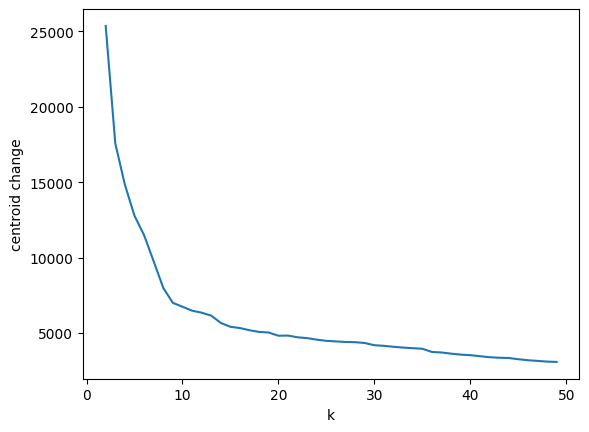

In [86]:
sns.lineplot(x=k_range, y  = kmeans_inertia)
plt.xlabel('k')
plt.ylabel('centroid change')

# Best K is 9. So 9 user groups

In [88]:
best_kmeans_user = KMeans(n_clusters=9)
df_user_rating_merged['cluster'] = best_kmeans_user.fit_predict(df_user_rating_merged)
df_user_rating_merged

,age,F,M,Drama,Children's,Animation,Musical,Comedy,Action,Thriller,...,Sci-Fi,Horror,Crime,Film-Noir,War,Mystery,Western,Fantasy,Documentary,cluster
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,1,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,1.000000,0,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.436364,0,1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.800000,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
5,0.436364,0,1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.436364,1,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
6037,0.800000,1,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
6038,1.000000,1,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6


In [109]:
df_genre

,genre,count
0,Animation,105
1,Children's,251
2,Comedy,1200
3,Adventure,283
4,Fantasy,68
5,Romance,471
6,Drama,1603
7,Action,503
8,Crime,211
9,Thriller,492


# 5 Popular movies in each cluster
# When a new user is assigned to a cluster recommend from these popular movies

In [137]:

pop_genre_cluster = {}
for cluster,group in df_user_rating_merged.groupby('cluster'):
    #print(group.count())
    cluster_genre = {}
    for col in df_genre['genre']:
        cluster_genre[col] = int(group[col].values.sum())
    top_5_genre =   sorted(cluster_genre.items(), key = lambda x : x[1], reverse= True)[:5]
    print(top_5_genre)
    pop_genre_cluster[cluster] = [g for g,cnt in top_5_genre]
    
pop_genre_cluster

[('Sci-Fi', 66), ('Drama', 65), ('Action', 65), ('Thriller', 64), ('Horror', 30)]
[('Crime', 449), ('Drama', 440), ('Thriller', 422), ('Action', 369), ('Comedy', 338)]
[('Action', 647), ('Sci-Fi', 615), ('Adventure', 613), ('Thriller', 599), ('Drama', 394)]
[('Thriller', 966), ('Drama', 943), ('Comedy', 893), ('Romance', 665), ('Action', 620)]
[('Comedy', 1147), ('Drama', 1088), ('Romance', 1021), ('Thriller', 898), ('Action', 666)]
[('Adventure', 653), ('Comedy', 650), ('Action', 631), ('Drama', 560), ('Sci-Fi', 342)]
[('Comedy', 485), ('Drama', 472), ('Action', 390), ('Romance', 382), ('Adventure', 230)]
[('Comedy', 805), ('Sci-Fi', 805), ('Action', 757), ('Thriller', 754), ('Drama', 748)]
[('Drama', 767), ('Comedy', 746), ('Action', 652), ('Romance', 440), ('War', 293)]


{0: ['Sci-Fi', 'Drama', 'Action', 'Thriller', 'Horror'],
 1: ['Crime', 'Drama', 'Thriller', 'Action', 'Comedy'],
 2: ['Action', 'Sci-Fi', 'Adventure', 'Thriller', 'Drama'],
 3: ['Thriller', 'Drama', 'Comedy', 'Romance', 'Action'],
 4: ['Comedy', 'Drama', 'Romance', 'Thriller', 'Action'],
 5: ['Adventure', 'Comedy', 'Action', 'Drama', 'Sci-Fi'],
 6: ['Comedy', 'Drama', 'Action', 'Romance', 'Adventure'],
 7: ['Comedy', 'Sci-Fi', 'Action', 'Thriller', 'Drama'],
 8: ['Drama', 'Comedy', 'Action', 'Romance', 'War']}

{0: {'Western': np.float64(2.0)},
 1: {'Western': np.float64(3.0)},
 2: {'Western': np.float64(3.0)},
 3: {'Western': np.float64(0.0)},
 4: {'Western': np.float64(4.0)},
 5: {'Western': np.float64(8.0)},
 6: {'Western': np.float64(5.0)},
 7: {'Western': np.float64(3.0)},
 8: {'Western': np.float64(32.0)}}